In [17]:
#Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!pip install geopandas

In [0]:
#check that drive is mounted properly
!ls /content/gdrive/'My Drive' | grep 'data'

In [20]:
import pandas as pd

crimeData = pd.read_csv('/content/gdrive/My Drive/Crime_Incidents.xls')
crimeData = crimeData.drop(columns=[':@computed_region_9cfm_spy5', ':@computed_region_43jd_v64e', ':@computed_region_ndi2_bfht'])
crimeData.head()

,ID,Incident Type,Report Date,Offense Date,Report Hour of Day,Report Day of Week,Offense Hour of Day,Offense Day of Week,City,State,Address,Latitude,Zip Code Boundaries,Longitude,Location,2010 Census Tracts,Commission Districts,Gainesville Police Districts,Florida Census Zip Codes
0,212001684,Information,01/24/2012 11:44:00 AM,01/24/2012 12:00:00 AM,11,Tuesday,0,Tuesday,GAINESVILLE,FL,1900 BLK NW 31ST AVE,29.681275,5.0,-82.347399,POINT (-82.347399 29.681275000000003),9.0,2.0,4.0,770.0
1,215003198,Assist Other Agency,02/16/2015 03:10:00 PM,02/15/2015 03:13:00 PM,15,Monday,15,Sunday,GAINESVILLE,FL,3000 BLK SW 100TH ST,29.626492,2.0,-82.448436,POINT (-82.448436 29.626492),NaN,NaN,10.0,767.0
2,216000029,Fire,01/01/2016 01:49:15 PM,01/01/2016 12:00:00 PM,13,Friday,12,Friday,GAINESVILLE,FL,600 BLK SW 4TH ST,29.646729,1.0,-82.328899,POINT (-82.328899 29.646729),1.0,1.0,1.0,772.0
3,217015619,Trespass Warning,08/24/2017 08:52:00 AM,08/24/2017 08:51:00 AM,8,Thursday,8,Thursday,GAINESVILLE,FL,2000 BLK SW 13TH ST,29.633356,2.0,-82.339436,POINT (-82.339436 29.633356000000003),6.0,4.0,3.0,767.0
4,217020565,Disturbance Civil,11/03/2017 05:32:00 PM,11/03/2017 05:30:00 PM,17,Friday,17,Friday,GAINESVILLE,FL,900 BLK NW 13TH ST,29.660298,5.0,-82.339173,POINT (-82.339173 29.660298),2.0,4.0,4.0,772.0


# Visualizations:

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 0, 'Hour of Day'),
 Text(0.5, 1.0, 'Gainesville Incident Count by Hour of Day')]

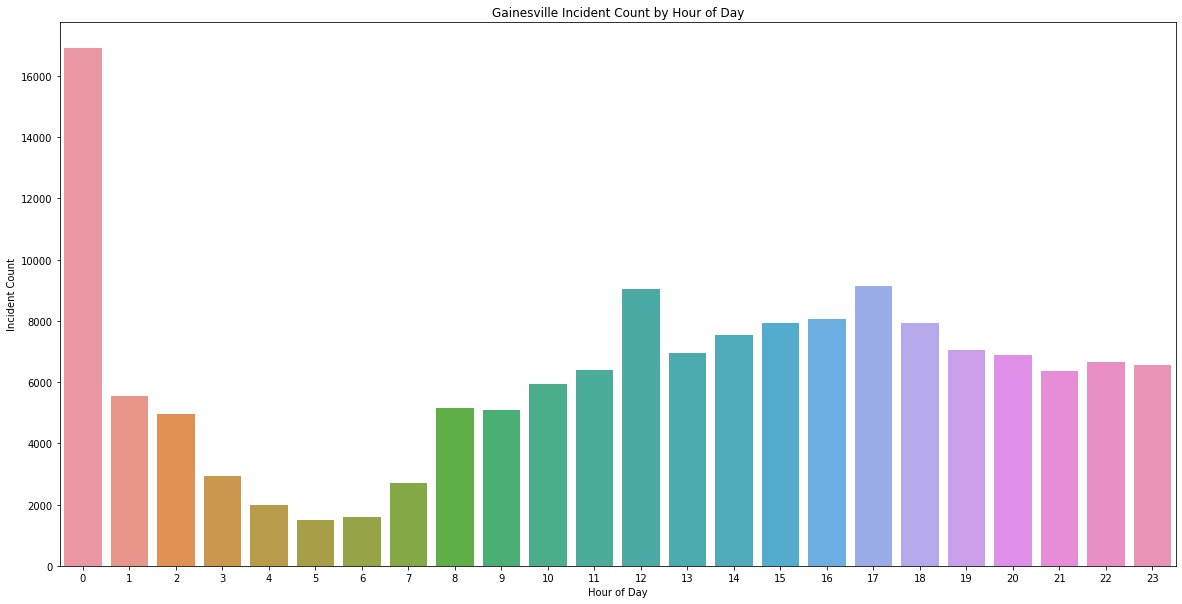

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
#num incidents per hour
numIncidentsPerHour = crimeData.groupby('Offense Hour of Day', as_index=False).count()
plt.figure(figsize=(20,10))
sns.barplot(x=numIncidentsPerHour['Offense Hour of Day'], y=numIncidentsPerHour['ID']).set(xlabel='Hour of Day', ylabel='Incident Count', title='Gainesville Incident Count by Hour of Day')

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 1.0, 'Gainesville Incident Count by Time Interval')]

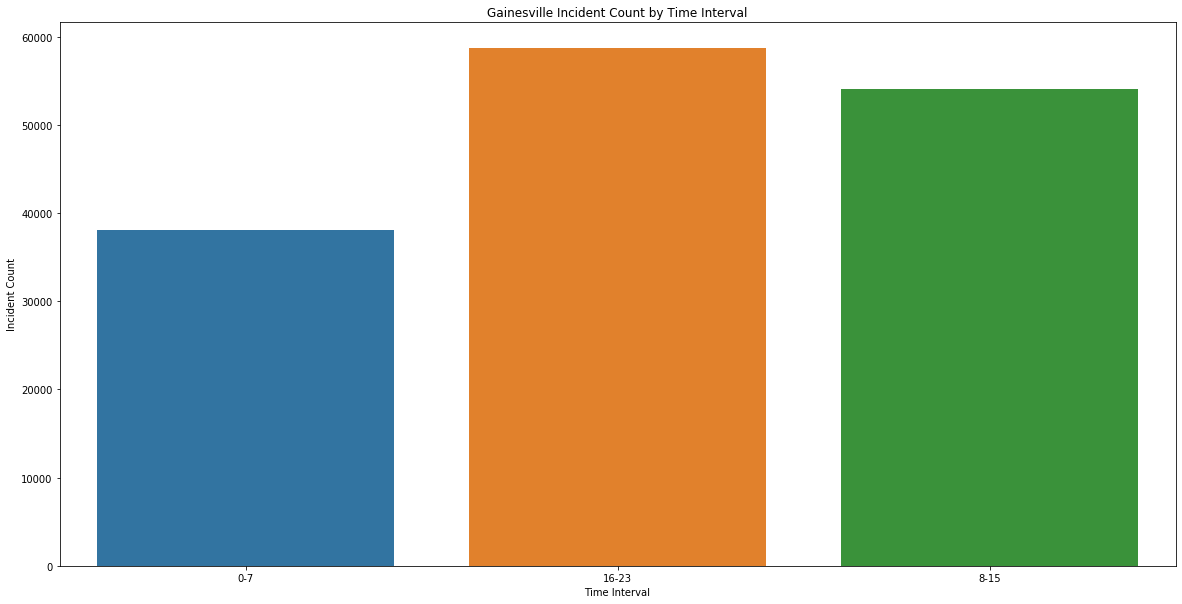

In [22]:
#Incidents by time interval of 8 hrs
def discTime(hr):
  if hr >= 0 and hr <= 7:
    return '0-7'
  if hr >= 8 and hr <= 15:
    return '8-15'
  if hr >= 16 and hr <= 23:
    return '16-23'

crimeData['Time Interval'] = crimeData.apply(lambda row: discTime(row['Offense Hour of Day']), axis=1)

incPerPeriod = crimeData.groupby('Time Interval', as_index=False).count()
plt.figure(figsize=(20,10))
sns.barplot(x=incPerPeriod['Time Interval'], y=incPerPeriod['ID']).set(ylabel='Incident Count', title='Gainesville Incident Count by Time Interval')

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 0, 'Weekday'),
 Text(0.5, 1.0, 'Gainesville Incident Count by Weekday')]

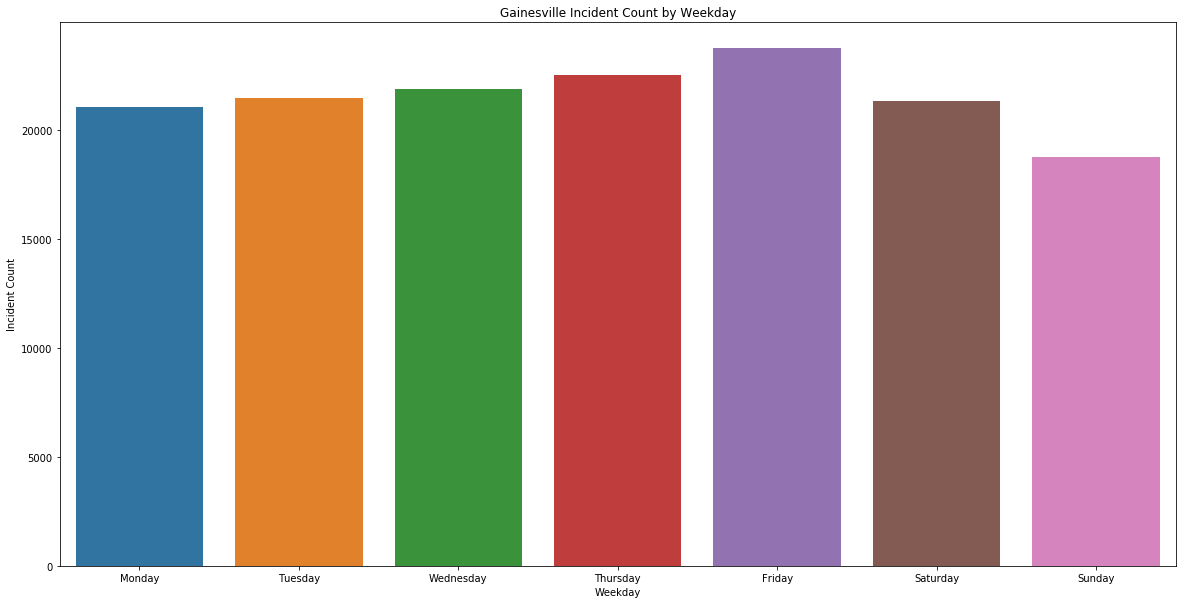

In [23]:
#Incident count by weekday
incPerDay = crimeData.groupby('Offense Day of Week', as_index=True).count().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
incPerDay['index'] = incPerDay.index
plt.figure(figsize=(20,10))
sns.barplot(x=incPerDay['index'], y=incPerDay['ID']).set(xlabel='Weekday', ylabel='Incident Count', title='Gainesville Incident Count by Weekday')

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 0, 'Incident Category'),
 Text(0.5, 1.0, 'Gainesville Incident Count per Incident Type')]

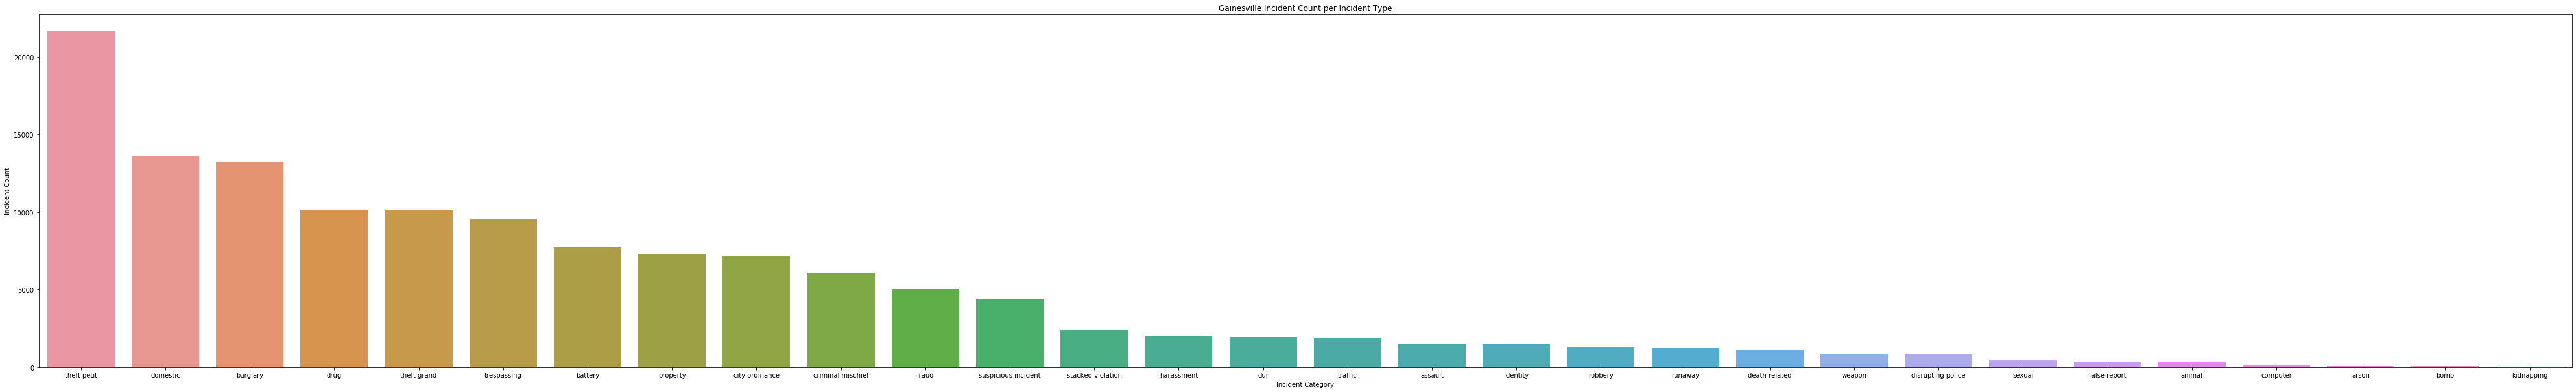

In [24]:
def f(x):
  if(x == 'animal' or x=='false report' or x=='computer' or x =='arson' or x=='bomb' or x =='sexual' or x=='kidnapping'):
    return 'other'
  return x

#Incidents per category
cat = pd.read_csv('/content/gdrive/My Drive/data - data.csv')
incPerCat = cat.groupby('Crime', as_index=False)['Crime'].agg(['count'])
incPerCat['cat'] = incPerCat.index
incPerCat = incPerCat[incPerCat['count'] >= 25]
incPerCat = incPerCat.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(70,10))
sns.barplot(x=incPerCat['cat'], y=incPerCat['count']).set(xlabel='Incident Category', ylabel='Incident Count', title='Gainesville Incident Count per Incident Type')

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Gainesville Incident Count by Year')]

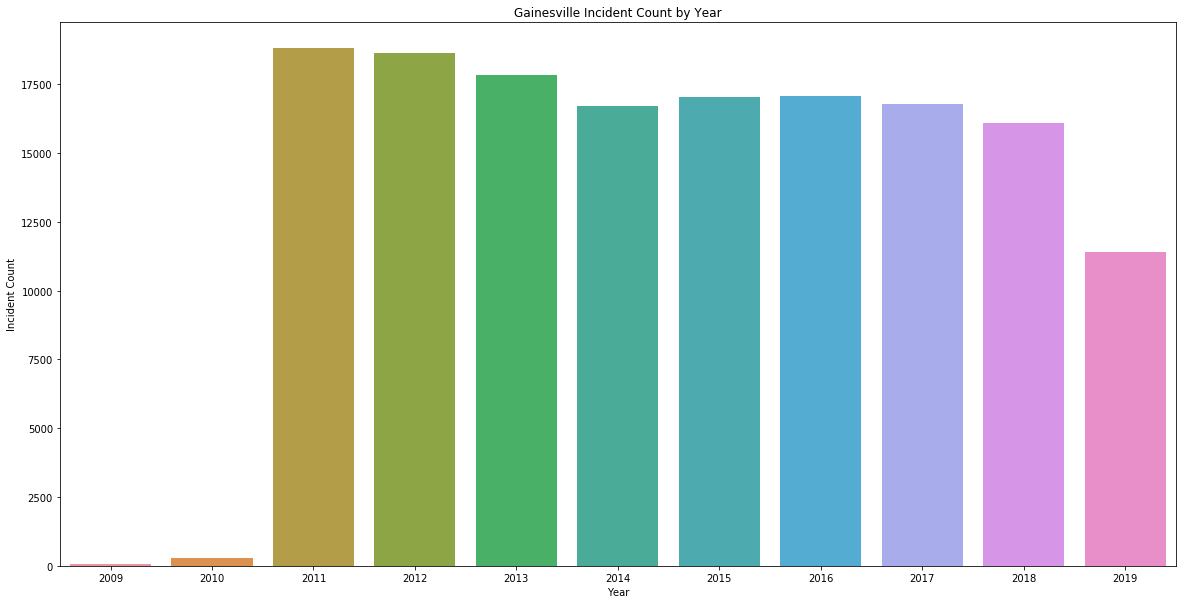

In [25]:
#Incident count by year
incPerYear = crimeData
incPerYear['Year'] = incPerYear.apply(lambda row: pd.to_datetime(row['Offense Date']).year, axis=1)
incPerYear = incPerYear.groupby('Year', as_index=False).count()
incPerYear = incPerYear[incPerYear['Year'] > 2008]
plt.figure(figsize=(20,10))
sns.barplot(x=incPerYear['Year'], y=incPerYear['ID']).set(xlabel='Year', ylabel='Incident Count', title='Gainesville Incident Count by Year')

[Text(0, 0.5, 'Incident Count'),
 Text(0.5, 0, 'Police District'),
 Text(0.5, 1.0, 'Gainesville Incident Count by Police District')]

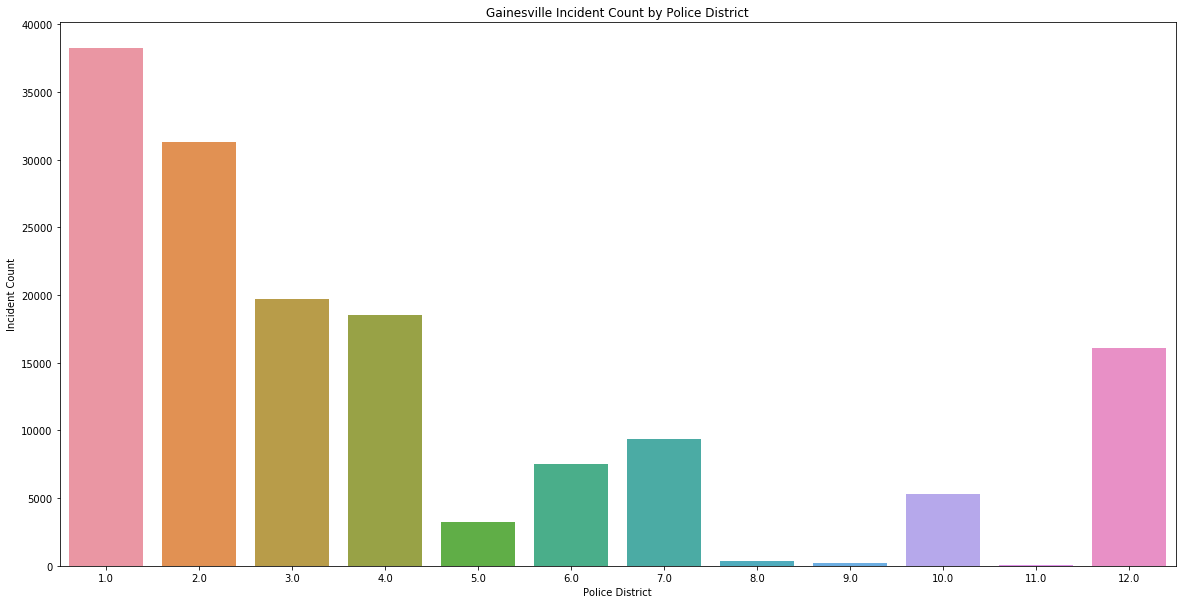

In [26]:
#Incident count by district
incPerDist = crimeData.groupby('Gainesville Police Districts', as_index=False).count()

plt.figure(figsize=(20,10))
sns.barplot(x=incPerDist['Gainesville Police Districts'], y=incPerDist['ID']).set(xlabel='Police District', ylabel='Incident Count', title='Gainesville Incident Count by Police District')

# Classification:

In [0]:
#Hourly count by Indcident Type
#chart = crimeData.groupby([''])

In [0]:
!pip install eli5

In [0]:
!pip install pdpbox

In [0]:
!pip install shap

In [0]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
#import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap

In [0]:
! SHAPE_RESTORE_SHX=YES fio info '/content/gdrive/My Drive/cgbound.shp'

In [0]:
gainesville = gpd.read_file('/content/gdrive/My Drive/cgbound.shp')
gainesville.crs={'init': 'epsg:4326'}
gville = gainesville.unary_union
gville

In [35]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import preprocessing

crimeData = pd.read_csv('/content/gdrive/My Drive/data - data.csv')

def discTime(hr):
  if hr == '0-7':
    return 1
  #if hr == '8 - 15':
  if hr == '16-23':
    return 3
  else:
   return 2

crimeData['Time'] = crimeData.apply(lambda row: discTime(row['Time']), axis=1)
crimeData

,District,Time,Day,Crime
0,3,2,Sunday,animal
1,1,2,Tuesday,animal
2,2,1,Monday,animal
3,1,2,Saturday,animal
4,3,3,Wednesday,animal
...,...,...,...,...
134624,2,2,Friday,weapon
134625,2,2,Wednesday,weapon
134626,12,1,Thursday,weapon
134627,7,2,Tuesday,weapon


In [0]:
le = preprocessing.LabelEncoder()
crimeData['Crime'] = le.fit_transform(crimeData['Crime'].astype(str))
crimeData['Crime'] = le.fit_transform(crimeData['Crime'])

le2 = preprocessing.LabelEncoder()
crimeData['Day'] = le.fit_transform(crimeData['Day'].astype(str))
crimeData['Day'] = le.fit_transform(crimeData['Day'])

In [37]:
y = crimeData['Crime']
crimeData = crimeData.drop(columns= 'Crime')
X_train, X_test, y_train, y_test = train_test_split(crimeData, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(107703, 3) (107703,)
(26926, 3) (26926,)


In [38]:
clf = linear_model.SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)